库引入

In [1]:
import numpy as np#用于数值计算
import matplotlib.pyplot as plt#用于绘制数据可视化图表
from matplotlib import rcParams  ## run command settings for plotting用于设置图形的默认参数
import pandas as pd#提供了高性能易用的数据结构和数据分析工具，特别适用于处理结构化数据。
from sklearn.model_selection import train_test_split#用于将数据集划分为训练集和测试集，以便进行机器学习模型的训练和评估。

图参数

In [2]:
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['SimHei'],
    "font.size": 10,   # 字号
    'axes.unicode_minus': False # 处理负号
}
rcParams.update(config)

读入数据

In [3]:
path = 'E:\\machine learning\\data\\regress_data1.csv'
data = pd.read_csv(path) ## data 是dataframe 的数据类型
data.head(10) # 返回data中的前几行数据，默认是前5行。观察数据  

,人口,收益
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233
5,8.3829,11.8860
6,7.4764,4.3483
7,8.5781,12.0000
8,6.4862,6.5987
9,5.0546,3.8166


In [4]:
cols = data.shape[1]
X_data = data.iloc[:,:cols-1]#X是所有行，去掉最后一列， 未标准化
Y_data = data.iloc[:,cols-1:]#X是所有行，最后一列
X_data.insert(0,'ones',1)
X=X_data.values#将目标变量转换为NumPy数组，存储在X中，以便后续的矩阵运算。
Y=Y_data.values#将目标变量转换为NumPy数组，存储在Y中，以便后续的矩阵运算。
W=np.array([[0.0],[0.0]])#W系数矩阵初始化
data.describe() ## 查看数据的统计信息

,人口,收益
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


数据处理

1.先将原始数据集划分为训练数据集和测试数据集

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=105)

2.保留训练数据集中的特征数据的均值和方差

In [6]:
x_train_mean=x_train[:, 1:2].mean()
x_train_std=x_train[:, 1:2].std()

3.对训练数据集标准化处理，并作散点图观察原始数据和归一化后的数据的的区别

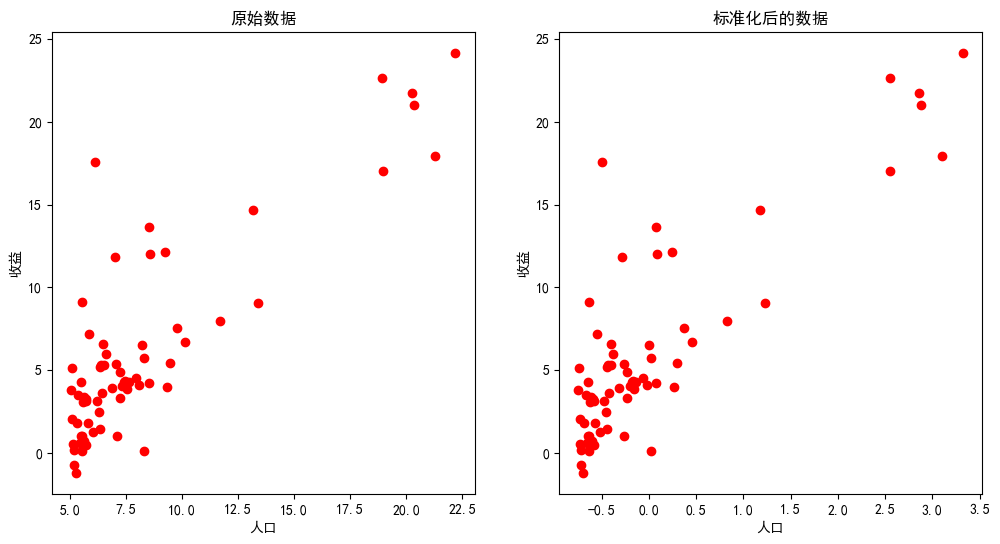

In [7]:
import matplotlib.pyplot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_train[:,1:2],y_train,'ro')
plt.title('原始数据')
plt.xlabel('人口')
plt.ylabel('收益')
x_train[:,1:2] = (x_train[:,1:2]-x_train_mean)/x_train_std#归一化后再一次作散点图
plt.subplot(1,2,2)
plt.plot(x_train[:, 1:2], y_train,'ro')
plt.title('标准化后的数据')
plt.xlabel('人口')
plt.ylabel('收益')
plt.show()

4.标准化测试数据x_test待用

In [8]:
x_test[:,1:2]=(x_test[:,1:2]-x_train_mean) / x_train_std

损失函数计算loss

注意***，根据维度，我们写出线性回归的模型：Y=np.dot(X,W) 也就是说  (m,n) @ (n, 1) -> (m, 1),
则线性回归模型写为：$${{f}}\left( X\right)=XW$$
因此，我们定义模型的损失函数为：$$ loss =\frac{(XW-Y)^T(XW-Y)}{2m}+\frac{\lambda}{2}\|\mathbf{W}\|_2^2$$

In [9]:
def computeCost(X,Y,W,lambda_):
    Y_hat=X@W
    mse_loss=np.sum((Y_hat-Y)**2)/(2*X.shape[0])
    L2=(lambda_/2)*np.sum(W**2)
    loss = mse_loss+L2
    return loss

批量梯度下降

**Batch Gradient Decent**
$${{w }_{j}}={{w }_{j}}- \alpha \frac{1}{m}\sum\limits_{i=1}^m \frac{\partial }{\partial {{w}_{j}}}J\left( w \right)={{w }_{j}}- \frac{\alpha}{m} X_j^T(f(X)-Y)-\lambda w_j$$

注意：这里 $X_j$代表所有样本第$j$个特征组成的向量，大小为$m\times1$，$f(X)$代表所有样本的预测值, $Y$为所有样本的预测值，大小为$m\times1$。 

写成矩阵的形式：
$${W}={W}- \alpha dW=W-\frac{\alpha X^T(f(X)-Y)}{m}-\lambda W$$



In [10]:
def gradientDescent(X, Y, W, lambda_, alpha):  
    num_train = X.shape[0] 
    Y_hat=X@W       
    dW=X.T@(Y_hat-Y)/num_train
#     dW = X.T@(Y_hat-Y)
    W += -alpha * dW-lambda_*W
    return W

线性回归模型

In [11]:
def linearRegression(x_train,y_train,x_test,y_test,alpha,lambda_,iters):
    train_loss_his =[]
    test_loss_his=[]
    # step1: initialize the model parameters
    feature_dim = x_train.shape[1]
    W=np.zeros((2,1)) ## 初始化W系数矩阵，w 是一个(feature_dim,1)矩阵
    ## repeat step 2 and step 3 untill to the convergence or the end of iterations
    for i in range (iters):
        # step2 : using the initilized parameters to predict the output and calculate the loss   
        loss = computeCost(x_train,y_train,W,lambda_)
        train_loss_his.append(loss)
        loss=computeCost(x_test,y_test,W,lambda_)
        test_loss_his.append(loss)
        # step3: using the gradient decent method to update the parameters 
        W=gradientDescent(x_train, y_train, W, lambda_, alpha)#梯度更新
    return train_loss_his,test_loss_his,W ## 返回损失和模型参数。

In [12]:
def predict(X, W):
    '''
    输入：
        X：测试数据集
        W：模型训练好的参数
    输出：
        y_pre：预测值
    '''
    y_pre = np.dot(X,W)
    return y_pre

调参

In [13]:
lambda_=0.001#控制正则化程度
alpha =0.01#学习率
iters = 10000#迭代次数

训练

In [14]:
train_loss_his,test_loss_his,W = linearRegression(x_train,y_train,x_test,y_test, alpha, lambda_, iters)

In [15]:
Wlsq=np.linalg.inv(np.dot(x_train.T,x_train))@x_train.T@y_train

绘制Ridge线性模型

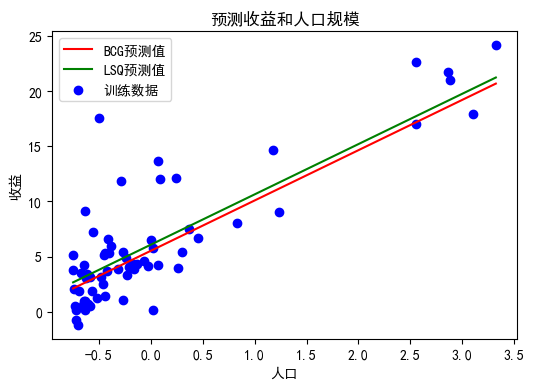

In [16]:
x = np.linspace(x_train[:,1].min(), x_train[:,1].max(), 100)
f = W[0, 0] + (W[1, 0] * x)
ff = Wlsq[0,0] + (W[1,0] * x)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, f,color='red' ,label='BCG预测值')
ax.plot(x, ff,color='green' ,label='LSQ预测值')
ax.scatter(x_train[:,1], y_train,color='blue' ,label='训练数据')
ax.legend(loc=2)
ax.set_xlabel('人口' )
ax.set_ylabel('收益', rotation=90)
ax.set_title('预测收益和人口规模')
plt.show()

绘制loss变化曲线

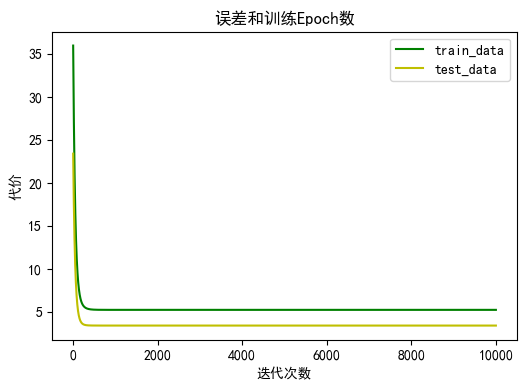

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(iters), train_loss_his,'g',label='train_data')
ax.plot(np.arange(iters), test_loss_his,'y',label='test_data')
ax.set_xlabel('迭代次数')
ax.set_ylabel('代价', rotation=90)
ax.set_title('误差和训练Epoch数')
ax.legend()
plt.show()